### Systematic comparison of topics across conditions using quantitative similarity measurement

We calculate the semantic similarity between the topics from the two conditions directly from the sentence embedding

1. Create a Single "Topic Vector": For each topic in both HS and DL, calculate its average vector. We do this by taking the sentence embeddings of all sentences assigned to that topic and averaging them. This gives a single vector that represents the semantic center of that topic.

2. Calculate Cosine Similarity: Use cosine similarity to measure the angle between each HS topic vector and each DL topic vector. The output will be a score between 0 and 1*, where 1 means they are semantically identical.

3. Visualise with a Heatmap: Place the HS topics on the Y-axis and the DL topics on the X-axis. The colour of each cell would represent the cosine similarity score between the two topics.



* (with modern sentence embeddings, instead of -1 to 1). This happens because of how models are trained (designed to place sentences with similar meanings closer in the vector space, so vectors they produce tend to exist in the "first quadrant" of the high-dimensional space ie  most of their component values are positive).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


import os,sys 
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)

from configs.dreamachine2 import config

dataset = 'dreamachine'
topic_content_HS = pd.read_csv(os.path.join(dataset, f"topics_content/topic_content_HS.csv"))
topic_content_DL = pd.read_csv(os.path.join(dataset, f"topics_content/topic_content_DL.csv"))

In [7]:
topic_content_HS.head()

,Topic_Label,Topic_Number,Sentence_Count,Content
0,Vivid Geometric Patterns and Colors,0,191,['A pattern of red and white lights that flash...
1,Out-of-Body Experiences and Altered States of ...,1,125,['And then my mind checked out and my subconsc...
2,Outlier,-1,68,"[""I couldn't help thinking what would happen w..."
3,Time-Space Portal Dynamics and Perception,3,58,"['Intense chaos.', 'Feeling of things coming a..."
4,Mindfulness-Based Sensory Experience for Calm ...,2,54,"['Being: immersed; calm; and thrilled.', 'Rela..."


In [9]:
df_hs = topic_content_HS
df_dl = topic_content_DL

hs_counts = df_hs.set_index('Topic_Label')['Sentence_Count'].rename('HS')
dl_counts = df_dl.set_index('Topic_Label')['Sentence_Count'].rename('DL')

contingency_table = pd.concat([hs_counts, dl_counts], axis=1).fillna(0).astype(int)

if 'Outlier' in contingency_table.index:
    contingency_table = contingency_table.drop('Outlier')

print("\n--- Contingency Table (Observed Frequencies) ---")
print(contingency_table)
print("-------------------------------------------------")


--- Contingency Table (Observed Frequencies) ---
                                                     HS  DL
Topic_Label                                                
Vivid Geometric Patterns and Colors                 191   0
Out-of-Body Experiences and Altered States of C...  125   0
Time-Space Portal Dynamics and Perception            58   0
Mindfulness-Based Sensory Experience for Calm a...   54   0
Spiritual or Meditative Experience with Euphori...   40   0
Subjective Experience of Therapeutic Potential       33   0
Nostalgic Flashbacks and Sense of Familiarity        29   0
Synesthetic Emotional Experience                     27   0
Phenomenological Experience of Disorientation a...   24   0
Visual Sensitivity to Flashing Light Intensity       24   0
Psychedelic Experience and Its Subjective Pheno...   14   0
Near-Death Experience and Existential Reflections    13   0
Mindfulness and Relaxation Through Sound Experi...    0  50
Spiritual Experiences of Connection and Self-Di...

In [15]:
# Define mapping of similar topics between HS and DL
merge_map = {
    # HS topic : DL topic
    'Time-Space Portal Dynamics and Perception': 'Imaginary Space-Time Experiences and Phenomenological States',
    'Out-of-Body Experiences and Altered States of Consciousness': 'Out-of-Body Experience',
    'Spiritual or Meditative Experience with Euphoric Sensations': 'Spiritual Experiences of Connection and Self-Discovery',
    'Mindfulness-Based Sensory Experience for Calm and Peace': 'Mindfulness and Relaxation Through Sound Experience'
}

# Create new labels for merged topics
def get_merged_label(row, condition):
    if condition == 'HS':
        if row['Topic_Label'] in merge_map:
            return f"{row['Topic_Label']} / {merge_map[row['Topic_Label']]}"
        else:
            return row['Topic_Label']
    else:  # DL
        for hs_label, dl_label in merge_map.items():
            if row['Topic_Label'] == dl_label:
                return f"{hs_label} / {dl_label}"
        return row['Topic_Label']

# Add merged labels to both dataframes
df_hs['Merged_Label'] = df_hs.apply(lambda row: get_merged_label(row, 'HS'), axis=1)
df_dl['Merged_Label'] = df_dl.apply(lambda row: get_merged_label(row, 'DL'), axis=1)

# Group by merged label and sum sentence counts
hs_counts_merged = df_hs.groupby('Merged_Label')['Sentence_Count'].sum().rename('HS')
dl_counts_merged = df_dl.groupby('Merged_Label')['Sentence_Count'].sum().rename('DL')

# Combine into new contingency table
contingency_table_merged = pd.concat([hs_counts_merged, dl_counts_merged], axis=1).fillna(0).astype(int)

# Remove 'Outlier' if present
if 'Outlier' in contingency_table_merged.index:
    contingency_table_merged = contingency_table_merged.drop('Outlier')

print("\n--- Merged Contingency Table ---")
print(contingency_table_merged)


--- Merged Contingency Table ---
                                                     HS  DL
Merged_Label                                               
Mindfulness-Based Sensory Experience for Calm a...   54  50
Near-Death Experience and Existential Reflections    13   0
Nostalgic Flashbacks and Sense of Familiarity        29   0
Out-of-Body Experiences and Altered States of C...  125  16
Phenomenological Experience of Disorientation a...   24   0
Psychedelic Experience and Its Subjective Pheno...   14   0
Spiritual or Meditative Experience with Euphori...   40  41
Subjective Experience of Therapeutic Potential       33   0
Synesthetic Emotional Experience                     27   0
Time-Space Portal Dynamics and Perception / Ima...   58  15
Visual Sensitivity to Flashing Light Intensity       24   0
Vivid Geometric Patterns and Colors                 191   0
Imagery and Perception of Aquatic Environments        0  19
Phenomenology of Visual Perception in Closed Eyes     0  27
The Po

In [16]:
# Define mapping of similar topics between HS and DL (already done above)
# Add The Power of Music on Spatial Perception to the merge for space-time topics

# Extended merge map for additional combination
extended_merge_map = merge_map.copy()
# Combine The Power of Music on Spatial Perception with the space-time topic merge
extended_merge_map['The Power of Music on Spatial Perception'] = 'Imaginary Space-Time Experiences and Phenomenological States'

def get_extended_merged_label(row, condition):
    # For HS topics
    if condition == 'HS':
        if row['Topic_Label'] in extended_merge_map:
            # For the space-time merge, include both DL topics in the label
            if row['Topic_Label'] == 'Time-Space Portal Dynamics and Perception':
                return f"{row['Topic_Label']} / Imaginary Space-Time Experiences and Phenomenological States / The Power of Music on Spatial Perception"
            elif row['Topic_Label'] == 'The Power of Music on Spatial Perception':
                return f"Time-Space Portal Dynamics and Perception / Imaginary Space-Time Experiences and Phenomenological States / {row['Topic_Label']}"
            else:
                return f"{row['Topic_Label']} / {extended_merge_map[row['Topic_Label']]}"
        else:
            return row['Topic_Label']
    # For DL topics
    else:
        for hs_label, dl_label in extended_merge_map.items():
            if row['Topic_Label'] == dl_label:
                if dl_label == 'Imaginary Space-Time Experiences and Phenomenological States':
                    return "Time-Space Portal Dynamics and Perception / Imaginary Space-Time Experiences and Phenomenological States / The Power of Music on Spatial Perception"
                else:
                    return f"{hs_label} / {dl_label}"
        if row['Topic_Label'] == 'The Power of Music on Spatial Perception':
            return "Time-Space Portal Dynamics and Perception / Imaginary Space-Time Experiences and Phenomenological States / The Power of Music on Spatial Perception"
        return row['Topic_Label']

# Apply new merged labels
df_hs['Merged_Label_Ext'] = df_hs.apply(lambda row: get_extended_merged_label(row, 'HS'), axis=1)
df_dl['Merged_Label_Ext'] = df_dl.apply(lambda row: get_extended_merged_label(row, 'DL'), axis=1)

# Group by new merged label and sum sentence counts
hs_counts_merged_ext = df_hs.groupby('Merged_Label_Ext')['Sentence_Count'].sum().rename('HS')
dl_counts_merged_ext = df_dl.groupby('Merged_Label_Ext')['Sentence_Count'].sum().rename('DL')

# Combine into new contingency table
contingency_table_merged_ext = pd.concat([hs_counts_merged_ext, dl_counts_merged_ext], axis=1).fillna(0).astype(int)

# Remove 'Outlier' if present
if 'Outlier' in contingency_table_merged_ext.index:
    contingency_table_merged_ext = contingency_table_merged_ext.drop('Outlier')

print("\n--- Extended Merged Contingency Table ---")
print(contingency_table_merged_ext)


--- Extended Merged Contingency Table ---
                                                     HS  DL
Merged_Label_Ext                                           
Mindfulness-Based Sensory Experience for Calm a...   54  50
Near-Death Experience and Existential Reflections    13   0
Nostalgic Flashbacks and Sense of Familiarity        29   0
Out-of-Body Experiences and Altered States of C...  125  16
Phenomenological Experience of Disorientation a...   24   0
Psychedelic Experience and Its Subjective Pheno...   14   0
Spiritual or Meditative Experience with Euphori...   40  41
Subjective Experience of Therapeutic Potential       33   0
Synesthetic Emotional Experience                     27   0
Time-Space Portal Dynamics and Perception / Ima...   58  29
Visual Sensitivity to Flashing Light Intensity       24   0
Vivid Geometric Patterns and Colors                 191   0
Imagery and Perception of Aquatic Environments        0  19
Phenomenology of Visual Perception in Closed Eyes     0  

In [20]:
contingency_table_merged_ext

,HS,DL
Merged_Label_Ext,,
Mindfulness-Based Sensory Experience for Calm and Peace / Mindfulness and Relaxation Through Sound Experience,54,50
Near-Death Experience and Existential Reflections,13,0
Nostalgic Flashbacks and Sense of Familiarity,29,0
Out-of-Body Experiences and Altered States of Consciousness / Out-of-Body Experience,125,16
Phenomenological Experience of Disorientation and Anxiety,24,0
Psychedelic Experience and Its Subjective Phenomenology,14,0
Spiritual or Meditative Experience with Euphoric Sensations / Spiritual Experiences of Connection and Self-Discovery,40,41
Subjective Experience of Therapeutic Potential,33,0
Synesthetic Emotional Experience,27,0


--- Chi-Squared Test Results ---
Chi-squared statistic: 354.74
P-value: 7.816429641030965e-68
Degrees of Freedom: 13

--- Interpretation ---
The p-value is extremely small (p < 0.001), indicating a highly statistically significant association between the condition (HS/DL) and the topics of experience reported.

Chart saved as topic_comparison_chart.png


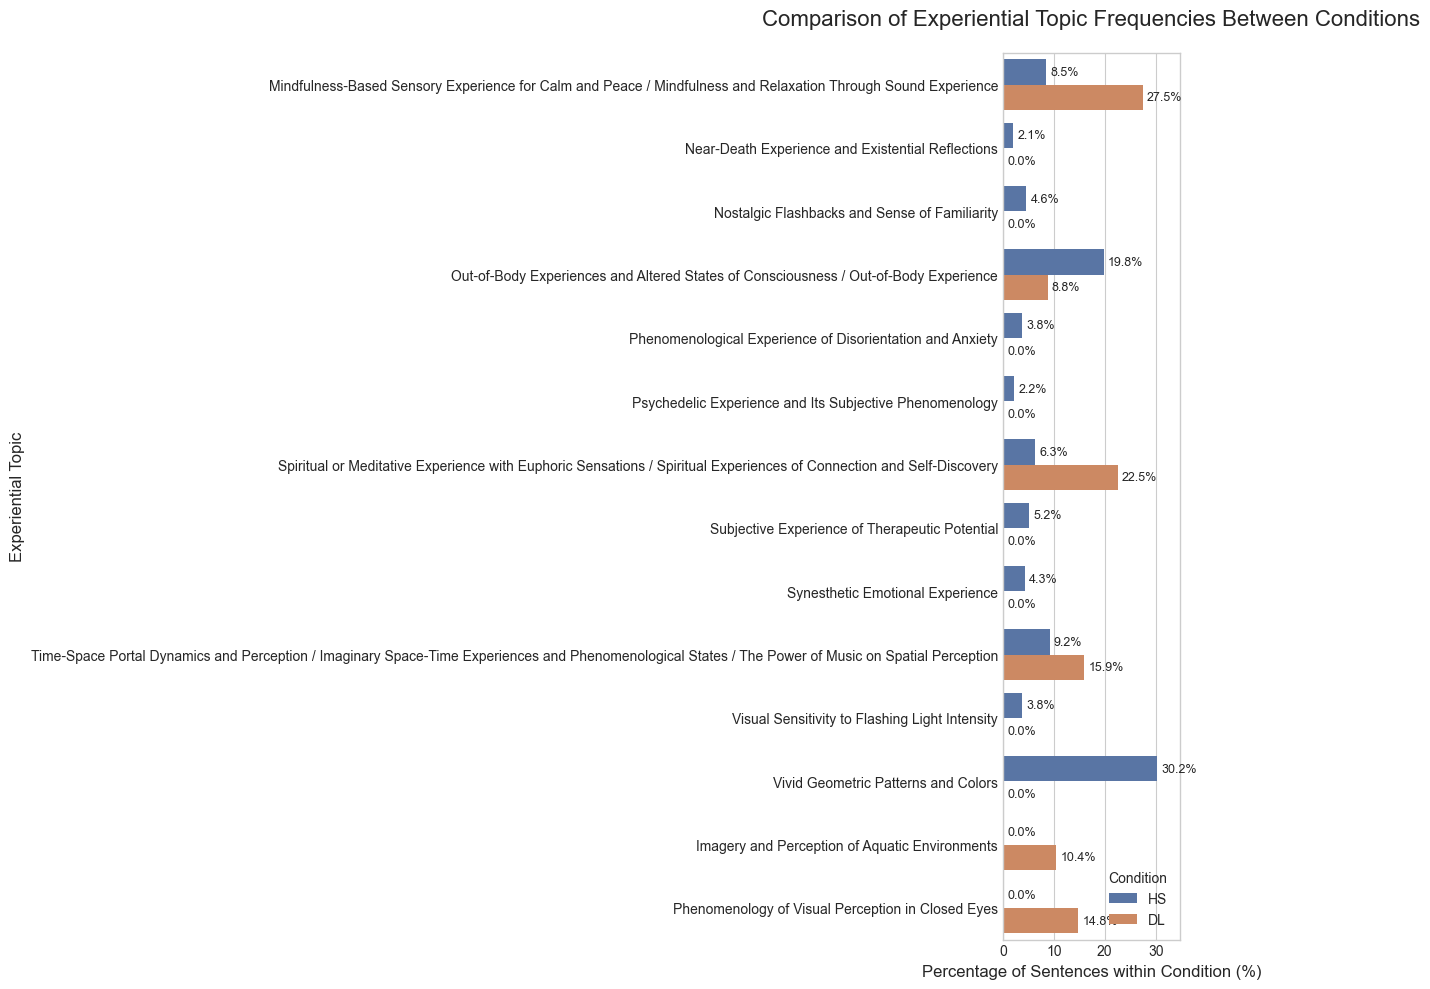

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# The script now uses your existing DataFrame: 'contingency_table_merged_ext'

# --- Chi-Squared Test ---
chi2, p_value, dof, expected = chi2_contingency(contingency_table_merged_ext)

print("--- Chi-Squared Test Results ---")
print(f"Chi-squared statistic: {chi2:.2f}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

# --- Interpretation ---
print("\n--- Interpretation ---")
if p_value < 0.001:
    print("The p-value is extremely small (p < 0.001), indicating a highly statistically significant association between the condition (HS/DL) and the topics of experience reported.")
else:
    print("The p-value is not significant.")

# --- Visualization ---

# Calculate percentages within each condition to normalize for sample size
percentage_table = contingency_table_merged_ext.div(contingency_table_merged_ext.sum(axis=0), axis=1) * 100

plot_data = percentage_table.reset_index().melt(id_vars='Merged_Label_Ext', var_name='Condition', value_name='Percentage')


# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 10))

sns.barplot(
    data=plot_data,
    y='Merged_Label_Ext',
    x='Percentage',
    hue='Condition',
    palette={'HS': '#4c72b0', 'DL': '#dd8452'},
    ax=ax
)

# Formatting
ax.set_title('Comparison of Experiential Topic Frequencies Between Conditions', fontsize=16, pad=20)
ax.set_xlabel('Percentage of Sentences within Condition (%)', fontsize=12)
ax.set_ylabel('Experiential Topic', fontsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.legend(title='Condition')

# Add percentage labels to the bars for clarity
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=9, padding=3)

# Adjust x-axis limit to give space for labels
ax.set_xlim(0, max(plot_data['Percentage']) * 1.15)

plt.tight_layout()
plt.savefig("topic_comparison_chart.png", dpi=300)
print("\nChart saved as topic_comparison_chart.png")

# Show the plot
plt.show()

### example with synthetic data for HS and DL conditions

In [27]:

hs_data = {
    'topic': [
        'HS_Peaceful_Experience', 'HS_Peaceful_Experience', 'HS_Peaceful_Experience',
        'HS_Childhood_Memories', 'HS_Childhood_Memories', 'HS_Childhood_Memories',
        'HS_Vivid_Visuals', 'HS_Vivid_Visuals', 'HS_Vivid_Visuals' # Unique to HS
    ],
    'text': [
        'I felt an overwhelming sense of calm.',
        'The experience was deeply relaxing and peaceful.',
        'A feeling of complete tranquility washed over me.',
        'I remembered playing in my grandmother\'s garden.',
        'Flashes of my past came back to me clearly.',
        'A specific memory from my school days appeared.',
        'I saw intense geometric shapes and spirals.',
        'Shockingly vivid white and red colors pulsed.',
        'The light created an angular kaleidoscope.'
    ]
}
hs_df = pd.DataFrame(hs_data)

dl_data = {
    'topic': [
        'DL_Peaceful_Experience', 'DL_Peaceful_Experience', 'DL_Peaceful_Experience',
        'DL_Childhood_Memories', 'DL_Childhood_Memories', 'DL_Childhood_Memories',
        'DL_Soundscape_Immersion', 'DL_Soundscape_Immersion', 'DL_Soundscape_Immersion' # Unique to DL
    ],
    'text': [
        'The music made me feel incredibly serene.',
        'I was so relaxed I felt like I was floating.',
        'It was a quiet and soothing journey inward.',
        'I thought about my family and our old home.',
        'A memory I hadn\'t thought of in years surfaced.',
        'I drifted back to moments from long ago.',
        'The music wasn\'t just in the space; it was the space.',
        'I felt the sound waves physically moving through me.',
        'The percussion and bass were a tangible presence.'
    ]
}
dl_df = pd.DataFrame(dl_data)

print("\n--- Synthetic Data Created ---")
print("HS Data:")
print(hs_df)
print("\nDL Data:")
print(dl_df)


--- Synthetic Data Created ---
HS Data:
                    topic                                               text
0  HS_Peaceful_Experience              I felt an overwhelming sense of calm.
1  HS_Peaceful_Experience   The experience was deeply relaxing and peaceful.
2  HS_Peaceful_Experience  A feeling of complete tranquility washed over me.
3   HS_Childhood_Memories   I remembered playing in my grandmother's garden.
4   HS_Childhood_Memories        Flashes of my past came back to me clearly.
5   HS_Childhood_Memories    A specific memory from my school days appeared.
6        HS_Vivid_Visuals        I saw intense geometric shapes and spirals.
7        HS_Vivid_Visuals      Shockingly vivid white and red colors pulsed.
8        HS_Vivid_Visuals         The light created an angular kaleidoscope.

DL Data:
                     topic                                               text
0   DL_Peaceful_Experience          The music made me feel incredibly serene.
1   DL_Peaceful_Experie

In [38]:
# Convert topic_content_HS to the same structure as hs_df
hs_df_full = topic_content_HS.explode('Content').reset_index(drop=True)
# If 'Content' is a string representation of a list, eval it first
if isinstance(hs_df_full.loc[0, 'Content'], str):
    hs_df_full = topic_content_HS.copy()
    hs_df_full['Content'] = hs_df_full['Content'].apply(eval)
    hs_df_full = hs_df_full.explode('Content').reset_index(drop=True)
hs_df_full = hs_df_full.rename(columns={'Topic_Label': 'topic', 'Content': 'text'})
hs_df_full = hs_df_full[['topic', 'text']]

# Convert topic_content_DL to the same structure as dl_df
dl_df_full = topic_content_DL.copy()
dl_df_full['Content'] = dl_df_full['Content'].apply(eval)
dl_df_full = dl_df_full.explode('Content').reset_index(drop=True)
dl_df_full = dl_df_full.rename(columns={'Topic_Label': 'topic', 'Content': 'text'})
dl_df_full = dl_df_full[['topic', 'text']]

print(hs_df_full.head())
print(dl_df_full.head())

                                 topic  \
0  Vivid Geometric Patterns and Colors   
1  Vivid Geometric Patterns and Colors   
2  Vivid Geometric Patterns and Colors   
3  Vivid Geometric Patterns and Colors   
4  Vivid Geometric Patterns and Colors   

                                                text  
0  A pattern of red and white lights that flashed...  
1                                   Hope as a color.  
2                 Incredible technicolor experience.  
3  At one point, the light darkened and my vision...  
4                    Incredible colors and patterns.  
                                               topic  \
0  Mindfulness and Relaxation Through Sound Exper...   
1  Mindfulness and Relaxation Through Sound Exper...   
2  Mindfulness and Relaxation Through Sound Exper...   
3  Mindfulness and Relaxation Through Sound Exper...   
4  Mindfulness and Relaxation Through Sound Exper...   

                                                text  
0  Not sure what the purp

In [40]:
dl_df_full

,topic,text
0,Mindfulness and Relaxation Through Sound Exper...,Not sure what the purpose of it was except bei...
1,Mindfulness and Relaxation Through Sound Exper...,This should be available for everyone all the ...
2,Mindfulness and Relaxation Through Sound Exper...,A doorway.
3,Mindfulness and Relaxation Through Sound Exper...,"Some visuals of trees, heat, sun-like experience."
4,Mindfulness and Relaxation Through Sound Exper...,Peacefulness and calm.
...,...,...
193,The Power of Music on Spatial Perception,I became more and more relaxed as the music pr...
194,The Power of Music on Spatial Perception,Emptiness in my mind; I was consumed by the po...
195,The Power of Music on Spatial Perception,"As the music's pace and volume increased, I sa..."
196,The Power of Music on Spatial Perception,"As the pace gathered further, I was on a train..."


In [ ]:
# # Flatten all sentences from the 'Content' column of topic_content_HS into a single list
# all_sentences_hs = [sentence for sublist in topic_content_HS['Content'] for sentence in eval(sublist)]
# print(len(all_sentences_hs))
# print(all_sentences_hs)

# all_sentences_dl = [sentence for sublist in topic_content_DL['Content'] for sentence in eval(sublist)]
# print(len(all_sentences_dl))
# print(all_sentences_dl)

700
['A pattern of red and white lights that flashed and became more intense when the lights flashed intensely.', 'Hope as a color.', 'Incredible technicolor experience.', "At one point, the light darkened and my vision shifted to a field of blue—one that I recognized as the same deep shade of Derek Jarman's film.", 'Incredible colors and patterns.', 'I tended to shift between focusing on the sound or the colors.', 'Geometric kaleidoscope shapes overlaid with moving cosmos/night sky slow exposure in different pulling directions.', 'I saw many shapes and colors, usually swirling and falling around me, as if I was moving through a vortex or a tunnel.', 'They were often red and orange, but sometimes bluey green, as if underwater.', 'I saw stars and hexagons tessellating, twisting, and zooming out left and right in reds, blues, and greens against a galactic background.', 'The vastness was just poetic and beautiful.', 'Numerous random shapes, sometimes geometric, sometimes just dots.', 'I w

In [ ]:
# # all_sentences_hs and all_sentences_dl are already lists of strings
# # To match the format of hs_df['text'], simply convert them to pandas Series

# hs_sentences_series = pd.Series(all_sentences_hs, name='text')
# dl_sentences_series = pd.Series(all_sentences_dl, name='text')

# print(hs_sentences_series.head())
# print(dl_sentences_series.head())

0    A pattern of red and white lights that flashed...
1                                     Hope as a color.
2                   Incredible technicolor experience.
3    At one point, the light darkened and my vision...
4                      Incredible colors and patterns.
Name: text, dtype: object
0    Not sure what the purpose of it was except bei...
1    This should be available for everyone all the ...
2                                           A doorway.
3    Some visuals of trees, heat, sun-like experience.
4                               Peacefulness and calm.
Name: text, dtype: object


### Generate sentence embeddings

In [ ]:
# # Load a pre-trained model
# model = SentenceTransformer(config.transformer_model)
# print(f"\n--- Loaded SentenceTransformer Model: {config.transformer_model} ---")

# # Generate embeddings for each sentence in the full HS and DL sentence series
# hs_sentences_series_embeddings = list(model.encode(hs_sentences_series.tolist()))
# dl_sentences_series_embeddings = list(model.encode(dl_sentences_series.tolist()))

# print(f"Generated {len(hs_sentences_series_embeddings)} embeddings for HS sentences.")
# print(f"Generated {len(dl_sentences_series_embeddings)} embeddings for DL sentences.")


--- Loaded SentenceTransformer Model: Qwen/Qwen3-Embedding-0.6B ---
Generated 700 embeddings for HS sentences.
Generated 198 embeddings for DL sentences.


In [43]:
# Load a pre-trained model
model = SentenceTransformer(config.transformer_model)
print(f"\n--- Loaded SentenceTransformer Model: {config.transformer_model} ---")

# # Generate embeddings for each dataset
hs_df_full['embedding'] = list(model.encode(hs_df_full['text']))
dl_df_full['embedding'] = list(model.encode(dl_df_full['text']))

print("\n--- Sentence Embeddings Generated ---")
print("Embeddings have been added as a new column to the DataFrames.")


--- Loaded SentenceTransformer Model: Qwen/Qwen3-Embedding-0.6B ---

--- Sentence Embeddings Generated ---
Embeddings have been added as a new column to the DataFrames.


In [44]:
# We group by topic and calculate the average embedding for that topic.

hs_topic_vectors = hs_df_full.groupby('topic')['embedding'].apply(np.mean)
dl_topic_vectors = dl_df_full.groupby('topic')['embedding'].apply(np.mean)

print("\n--- Topic Vectors Created ---")
print("HS Topics:")
print(hs_topic_vectors.index.tolist())
print("\nDL Topics:")
print(dl_topic_vectors.index.tolist())



--- Topic Vectors Created ---
HS Topics:
['Mindfulness-Based Sensory Experience for Calm and Peace', 'Near-Death Experience and Existential Reflections', 'Nostalgic Flashbacks and Sense of Familiarity', 'Out-of-Body Experiences and Altered States of Consciousness', 'Outlier', 'Phenomenological Experience of Disorientation and Anxiety', 'Psychedelic Experience and Its Subjective Phenomenology', 'Spiritual or Meditative Experience with Euphoric Sensations', 'Subjective Experience of Therapeutic Potential', 'Synesthetic Emotional Experience', 'Time-Space Portal Dynamics and Perception', 'Visual Sensitivity to Flashing Light Intensity', 'Vivid Geometric Patterns and Colors']

DL Topics:
['Imagery and Perception of Aquatic Environments', 'Imaginary Space-Time Experiences and Phenomenological States', 'Mindfulness and Relaxation Through Sound Experience', 'Out-of-Body Experience', 'Outlier', 'Phenomenology of Visual Perception in Closed Eyes', 'Spiritual Experiences of Connection and Self-D

### Calculate Cosine Similarity Between HS and DL Topics

In [45]:
# Create a matrix to store the similarity scores
similarity_matrix = pd.DataFrame(index=hs_topic_vectors.index, columns=dl_topic_vectors.index)

# Loop through each pair of topics and calculate their similarity
for hs_topic, hs_vector in hs_topic_vectors.items():
    for dl_topic, dl_vector in dl_topic_vectors.items():
        # Reshape vectors for the function
        sim_score = cosine_similarity(hs_vector.reshape(1, -1), dl_vector.reshape(1, -1))
        similarity_matrix.loc[hs_topic, dl_topic] = sim_score[0, 0]

# Convert the matrix to float type for the heatmap
similarity_matrix = similarity_matrix.astype(float)

print("\n--- Cosine Similarity Matrix ---")
print(similarity_matrix)



--- Cosine Similarity Matrix ---
topic                                               Imagery and Perception of Aquatic Environments  \
topic                                                                                                
Mindfulness-Based Sensory Experience for Calm a...                                        0.697538   
Near-Death Experience and Existential Reflections                                         0.720553   
Nostalgic Flashbacks and Sense of Familiarity                                             0.781721   
Out-of-Body Experiences and Altered States of C...                                        0.870808   
Outlier                                                                                   0.853464   
Phenomenological Experience of Disorientation a...                                        0.768115   
Psychedelic Experience and Its Subjective Pheno...                                        0.670985   
Spiritual or Meditative Experience with Euphori.


--- Generating Heatmap ---


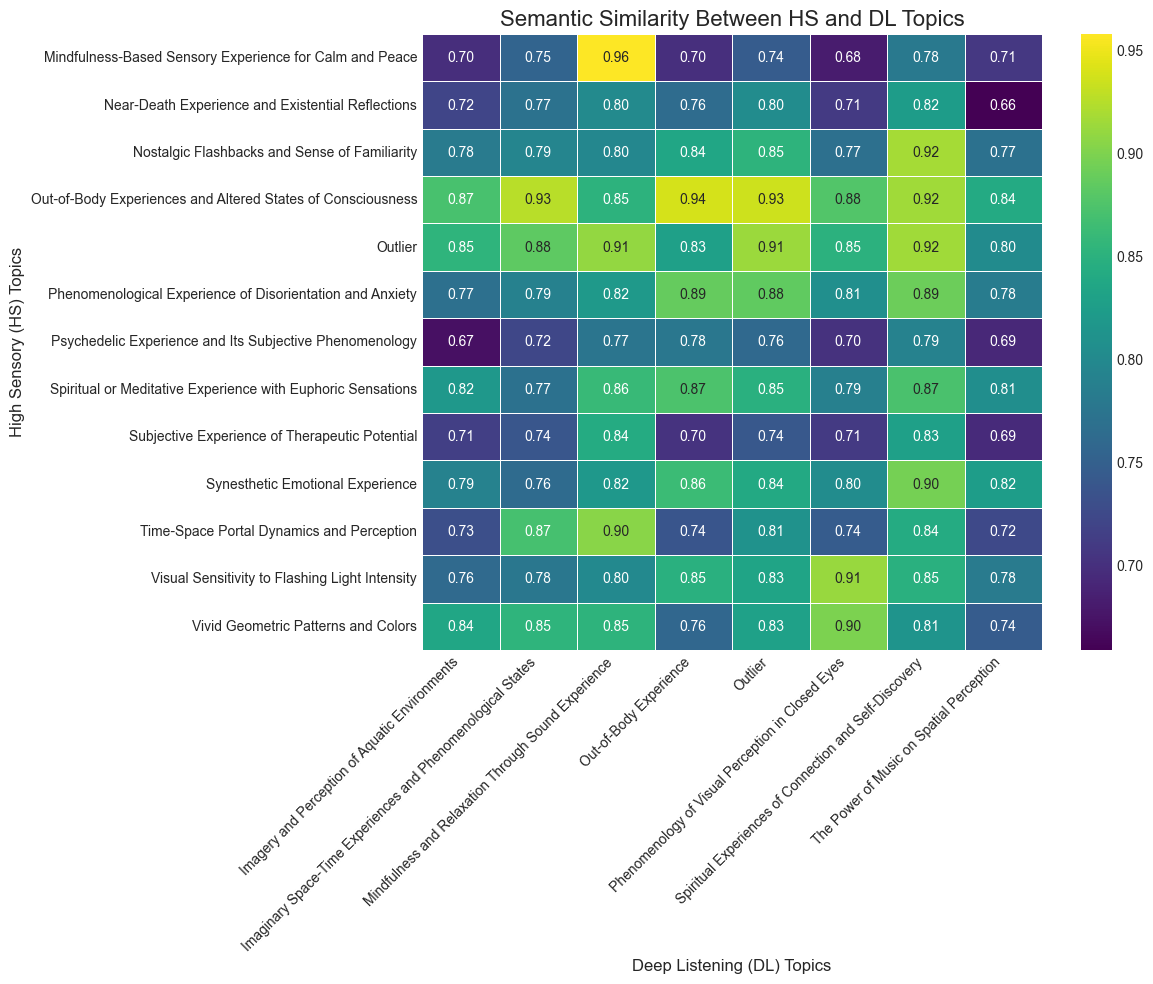

In [46]:
print("\n--- Generating Heatmap ---")

plt.figure(figsize=(10, 8))
sns.heatmap(
    similarity_matrix,
    annot=True,          # Show the similarity scores in each cell
    cmap='viridis',      # Use a color-friendly palette
    linewidths=.5,
    fmt=".2f"            # Format scores to two decimal places
)
plt.title('Semantic Similarity Between HS and DL Topics', fontsize=16)
plt.xlabel('Deep Listening (DL) Topics', fontsize=12)
plt.ylabel('High Sensory (HS) Topics', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()



### Help understand averaging of vectors

/Users/rb666/Projects/MOSAIC/.mosaicvenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


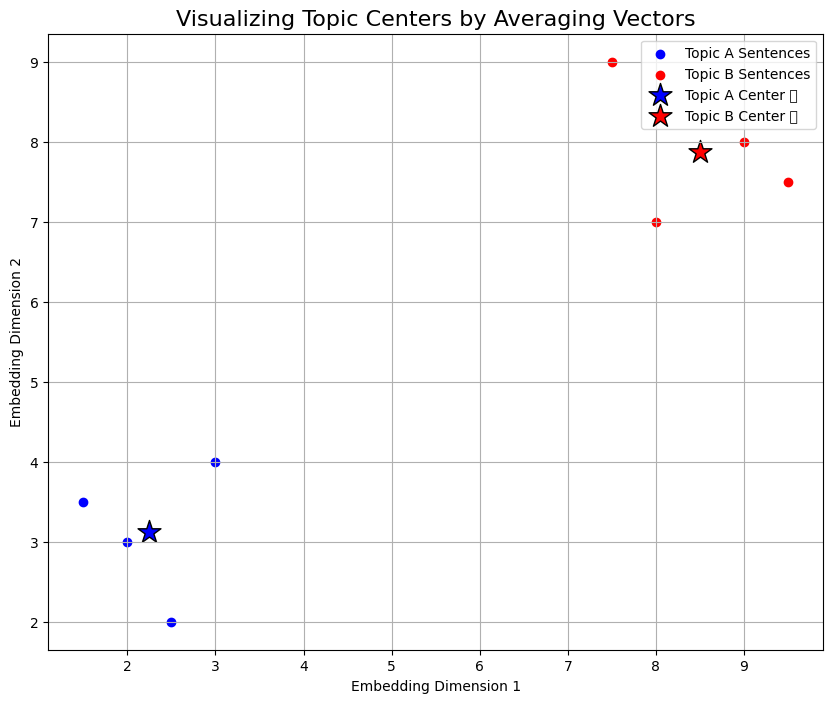

Center of Topic A: [2.25  3.125]
Center of Topic B: [8.5   7.875]


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Create Synthetic "Sentence" Embeddings (in 2D for visualization) ---
# Imagine these are sentences about a 'Peaceful Experience'
topic_A_sentences = np.array([
    [2, 3],
    [3, 4],
    [2.5, 2],
    [1.5, 3.5]
])

# Imagine these are sentences about 'Childhood Memories'
topic_B_sentences = np.array([
    [8, 7],
    [9, 8],
    [7.5, 9],
    [9.5, 7.5]
])

# --- 2. Calculate the "Topic Vector" (the Centroid) by Averaging ---
# The np.mean(axis=0) calculates the mean down each column (the x's and y's)
topic_A_center = np.mean(topic_A_sentences, axis=0)
topic_B_center = np.mean(topic_B_sentences, axis=0)

# --- 3. Plot Everything ---
plt.figure(figsize=(10, 8))

# Plot the individual "sentence" points
plt.scatter(topic_A_sentences[:, 0], topic_A_sentences[:, 1], c='blue', label='Topic A Sentences')
plt.scatter(topic_B_sentences[:, 0], topic_B_sentences[:, 1], c='red', label='Topic B Sentences')

# Plot the central "topic vector" points
plt.scatter(topic_A_center[0], topic_A_center[1], c='blue', marker='*', s=300, edgecolor='black', label='Topic A Center 🎯')
plt.scatter(topic_B_center[0], topic_B_center[1], c='red', marker='*', s=300, edgecolor='black', label='Topic B Center 🎯')

plt.title('Visualizing Topic Centers by Averaging Vectors', fontsize=16)
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

print("Center of Topic A:", topic_A_center)
print("Center of Topic B:", topic_B_center)

Similarity between A and B: 1.00 (Very high, as expected)
Similarity between A and C: 0.77 (Lower, as expected)


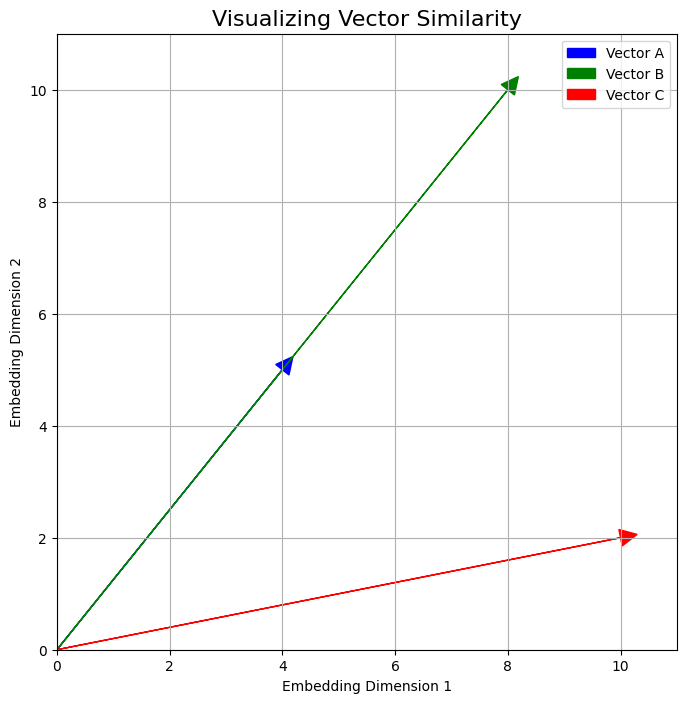

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# --- 1. Define three synthetic "Topic Vectors" in 2D ---
vec_A = np.array([4, 5])
vec_B = np.array([8, 10]) # Points in the same direction as A, but is longer
vec_C = np.array([10, 2]) # Points in a different direction

# --- 2. Calculate Cosine Similarity ---
# The function expects 2D arrays, so we use .reshape(1, -1)
sim_A_B = cosine_similarity(vec_A.reshape(1, -1), vec_B.reshape(1, -1))
sim_A_C = cosine_similarity(vec_A.reshape(1, -1), vec_C.reshape(1, -1))

print(f"Similarity between A and B: {sim_A_B[0,0]:.2f} (Very high, as expected)")
print(f"Similarity between A and C: {sim_A_C[0,0]:.2f} (Lower, as expected)")


# --- 3. Plot the Vectors ---
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Draw the arrows
ax.arrow(0, 0, vec_A[0], vec_A[1], head_width=0.3, head_length=0.3, fc='blue', ec='blue', label='Vector A')
ax.arrow(0, 0, vec_B[0], vec_B[1], head_width=0.3, head_length=0.3, fc='green', ec='green', label='Vector B')
ax.arrow(0, 0, vec_C[0], vec_C[1], head_width=0.3, head_length=0.3, fc='red', ec='red', label='Vector C')

# Formatting the plot
ax.set_xlim([0, 11])
ax.set_ylim([0, 11])
ax.set_xlabel('Embedding Dimension 1')
ax.set_ylabel('Embedding Dimension 2')
ax.set_title('Visualizing Vector Similarity', fontsize=16)
ax.legend()
plt.grid(True)
plt.show()